In [1]:
import keras
from src.utilities import load_data_as_set_of_particles
from src.Models.MLP import MLP
from src.Models.PointNet import PointNet
from src import utilities

#### Loading the Data

In [2]:
# Creating the trainning, validation and test set
X_train, y_train = load_data_as_set_of_particles("../Data/HiggsTrainning.csv")
X_val, y_val = load_data_as_set_of_particles("../Data/HiggsValidation.csv")
X_test, y_test = load_data_as_set_of_particles("../Data/HiggsTest.csv")

#### Defining the Model

In [5]:
# Defining the MLP that will be used for all the particles
input_mlp = keras.layers.Input(shape=[7])
mlp = MLP(num_neurons=32)
mlp_model = keras.Model(inputs=input_mlp, outputs=mlp(input_mlp))

# creating the PointNet
input_point_net = keras.layers.Input(shape=[6, 7])
point_net = PointNet(mlp=mlp_model, mlp_output_dim=32)(input_point_net)
output_layer = keras.layers.Dense(2, activation='softmax')(point_net)

# final model
model = keras.Model(inputs=input_point_net, outputs=output_layer)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ point_net (PointNet)            │ (None, 64)             │         9,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,154 (35.76 KB)

 Trainable params: 8,962 (35.01 KB)

 Non-trainable params: 192 (768.00 B)

In [6]:
model.compile(optimizer='adam', loss='crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 587us/step - accuracy: 0.5480 - loss: 0.6853 - val_accuracy: 0.5918 - val_loss: 0.6622
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - accuracy: 0.5924 - loss: 0.6637 - val_accuracy: 0.6035 - val_loss: 0.6598
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - accuracy: 0.5981 - loss: 0.6600 - val_accuracy: 0.6060 - val_loss: 0.6527
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - accuracy: 0.6013 - loss: 0.6556 - val_accuracy: 0.6148 - val_loss: 0.6488
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - accuracy: 0.6089 - loss: 0.6523 - val_accuracy: 0.6185 - val_loss: 0.6466
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - accuracy: 0.6090 - loss: 0.6512 - val_accuracy: 0.6212 - val_loss: 0.6464
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.6119 - loss: 0.6511 - val_accuracy: 0.6227 - val_loss: 0.6468
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 

#### Quick checks

In [7]:
# perfoming the prediction
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


In [8]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train, y_pred=y_train_pred)
print("Validation set:")
utilities.display_metrics(y_true=y_val, y_pred=y_val_pred)
print("Test set:")
utilities.display_metrics(y_true=y_test, y_pred=y_test_pred)

Trainnig set:
Recall: 0.7287
Precision: 0.6569
Confusion Matrix:
[[17352 12858]
 [ 9168 24622]]
Validation set:
Recall: 0.7116
Precision: 0.6396
Confusion Matrix:
[[4173 3385]
 [2435 6007]]
Test set:
Recall: 0.7154
Precision: 0.6422
Confusion Matrix:
[[5173 4226]
 [3017 7585]]


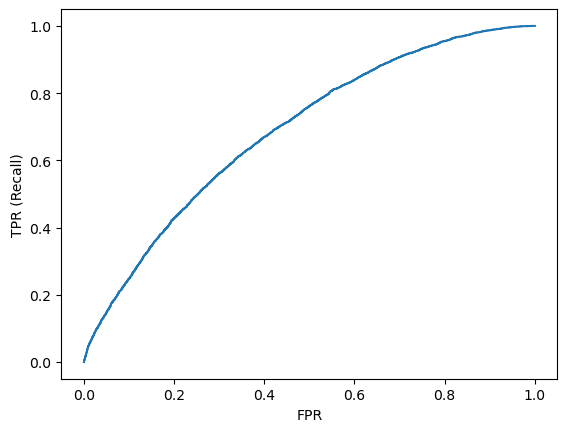

AUC: 0.6889


In [9]:
utilities.display_roc_curve(y_true=y_val, y_pred=y_val_pred)

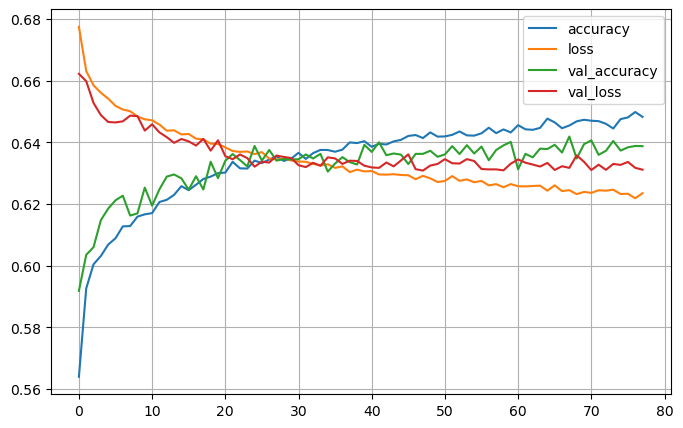

In [10]:
utilities.plot_hist_trainning(history)

In [11]:
utilities.save_model(model, history, "ModelFiles/PointNet")